In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from datetime import datetime

# Read data

In [2]:
def mkFuturesData(turtle_f, bar_f):
    '''append turtle and barchart data extract only price for given month'''
    turtle = pd.read_csv(turtle_f)
    bar = pd.read_csv(bar_f)
    df = turtle.append(bar)
    df['date'] = pd.to_datetime(df['date'])
    df = df.drop_duplicates(subset=['date', 'year','month'])
    # df['close'] = df['close'].astype(float)/100.
    df = df.sort_values('date')
    df = df.reset_index(drop=True)

    return df

In [3]:
# data = pd.read_csv('corn.csv')
data = mkFuturesData('corn.csv', 'corn_barchart_new.csv')

In [6]:
data.to_csv('all_corn.csv')

## Columns (fields)

In [4]:
data.columns

Index(['year', 'month', 'open', 'close', 'open_net', 'close_net', 'open_rel',
       'close_rel', 'volume', 'openint', 'day', 'date'],
      dtype='object')

## Contract information

In [5]:
_m = data['month'].unique()
_y = data['year'].drop_duplicates().sort_values()
print("{} years from {} to {}".format(len(_y), _y.iloc[0], _y.iloc[-1]))
print("months: {}".format(_m))
_nmonths = len(_m)
_nyears = len(_y)
_contracts = data[['year', 'month']].drop_duplicates()
_ncontracts = len(_contracts)
_npossible = _nmonths * _nyears
print('Num of contracts {} {} possible {}'.format(_ncontracts, '=' if _ncontracts == _npossible else '<', _npossible ))

61 years from 1959 to 2019
months: [ 5  9  3 12  7]
Num of contracts 301 < possible 305


# Support code

In [6]:
# plots important data for a single contract (year & month)
def contractPlots(df, year, month, which='anrvi'):
    '''which selects among the 5 plots.
    a: absolute; n: net; r: relative; v: volume; i: openint'''
    plots = 'anrvi'
    which = which.lower()
    for a in which:
        assert a in plots, 'invalid plot specification: must be in "{}"'.format(plots)
    
    print("Plots for contract {}/{}".format(year, month))
    
    row = df[(df['year'] == year) & (df['month'] == month)]

    nplots = len(which)
    plt.rcParams["figure.figsize"]=20,4*nplots

    this_plot = 1
    # absolute open/close
    if 'a' in which:
        ax = plt.subplot(nplots, 1, this_plot)
        ax.invert_xaxis()

        plt.plot(row['day'], row['close'], 'r-', label="close")
        plt.plot(row['day'], row['open'], 'b-', label='open')
        plt.axhline(y=row.iloc[0]['close'], color='green')
        plt.axhline(y=row.iloc[-1]['close'], color='red')
        plt.grid(b=True, which='major')
        plt.ylabel('Cents/bushel')
        plt.title('Price')
        plt.legend()
        
        this_plot += 1
    
    # net open/close
    if 'n' in which:
        ax = plt.subplot(nplots, 1, this_plot)
        ax.invert_xaxis()

        plt.plot(row['day'], row['close_net'], 'r-', label="close")
        plt.plot(row['day'], row['open_net'], 'b-', label='open')
        plt.grid(b=True, which='major')
        plt.ylabel('Net (cents)')
        plt.title('Price')
        plt.legend()
    
        this_plot += 1

    # relative open/colse
    if 'r' in which:
        ax = plt.subplot(nplots, 1, this_plot)
        ax.invert_xaxis()
        plt.plot(row['day'], row['close_rel'], 'r-', label="close")
        plt.plot(row['day'], row['open_rel'], 'b-', label='open')
        plt.grid(b=True, which='major')
        plt.ylabel('Relative')
        plt.title('Price')
        plt.legend()

        this_plot += 1


    # volume
    if 'v' in which:
        ax = plt.subplot(nplots, 1, this_plot)
        plt.ylabel('Contracts')

        y2 = ax.twinx()
        ax.invert_xaxis()

        y2.plot(row['day'], row['volume'].cumsum()/1000000, 'r-', label='Cumulative')
        ax.plot(row['day'], row['volume'], 'b-', label='Daily')
        plt.grid(b=True, which='major')
        plt.ylabel('Contracts (M)')
        plt.title('Volume')
        plt.legend()

        this_plot += 1

    # openint
    if 'i'in which:
        ax = plt.subplot(nplots, 1, this_plot)
        ax.invert_xaxis()
        plt.plot(row['day'], row['openint'], 'b-')
        plt.grid(b=True, which='major')
        plt.ylabel('Contracts')
        plt.title('Open Interest')
        plt.show()
    
def yearPlots(df, year):
    yeardata = df[df['year'] == year]
    months = yeardata['month'].unique()
    for month in months:
        contractPlots(data, year, month)

## Contract plots one contract

Plots for contract 2019/9


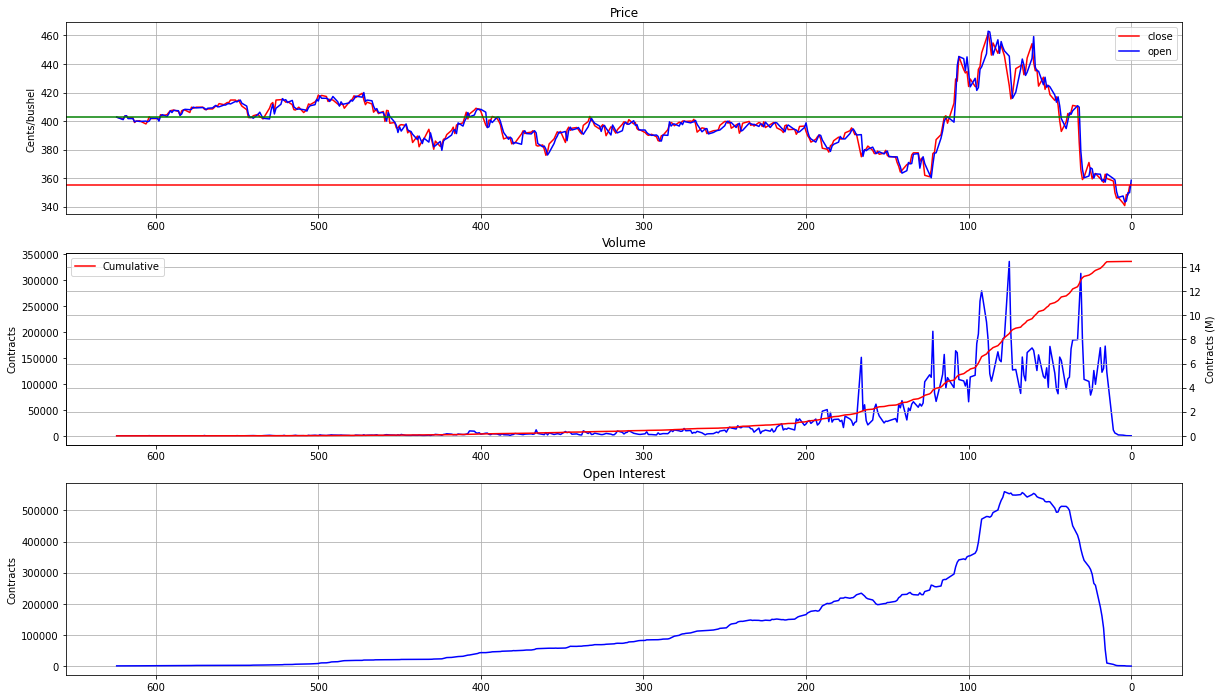

In [7]:
year = 2019
month = 9
contractPlots(data, year, month, which='vai')

# Contract plots for a year

In [8]:
#yearPlots(data, 1973)

# Anomalies
Find outliers

In [9]:
# @ 30 days more the 20% different from final
days = 30
diff = 1.2
data[(data['day']==days) & ((data['close_rel'] < 1/diff) | (data['close_rel'] > diff))]

,year,month,open,close,open_net,close_net,open_rel,close_rel,volume,openint,day,date
17503,1973,7,236.00,232.00,-144.00,-148.00,0.621053,0.610526,26620,86480,30,1973-06-20
17701,1973,9,330.00,311.50,86.25,67.75,1.353846,1.277949,14585,65595,30,1973-08-20
52296,1994,7,274.00,271.25,48.75,46.00,1.216426,1.204218,72540,358990,30,1994-06-20
81980,2009,7,439.50,425.50,89.50,75.50,1.255714,1.215714,146802,254854,30,2009-06-12
87893,2012,7,582.25,592.50,-173.50,-163.25,0.770427,0.783989,214591,306187,30,2012-06-13
93778,2015,7,356.00,353.00,-68.00,-71.00,0.839623,0.832547,223042,404386,30,2015-06-12
95755,2016,7,429.50,436.50,67.25,74.25,1.185645,1.204969,236330,325753,30,2016-06-14


In [10]:
# @ 60 days more the 25% different from final
days = 60
diff = 1.25
data[(data['day']==days) & ((data['close_rel'] < 1/diff) | (data['close_rel'] > diff))]

,year,month,open,close,open_net,close_net,open_rel,close_rel,volume,openint,day,date
17164,1973,5,157.75,162.37,-45.75,-41.13,0.775184,0.797887,25655,137160,60,1973-03-22
17396,1973,7,185.00,189.37,-195.00,-190.63,0.486842,0.498342,62690,167165,60,1973-05-21
18788,1974,7,259.00,261.00,-71.50,-69.50,0.783661,0.789713,29510,121135,60,1974-05-23
29321,1981,9,340.75,342.25,67.75,69.25,1.248168,1.253663,63185,173530,60,1981-07-23
56289,1996,5,387.50,390.00,-137.00,-134.50,0.738799,0.743565,164640,935485,60,1996-03-22
64708,2000,7,240.75,238.75,65.50,63.50,1.373752,1.362340,78788,246811,60,2000-05-15
87724,2012,7,582.00,583.00,-173.75,-172.75,0.770096,0.771419,106879,536758,60,2012-05-14
101009,2019,7,351.00,356.50,-98.50,-93.00,0.780868,0.793103,281888,831036,60,2019-05-13


In [11]:
# @ 90 days more the 30% different from final
days = 90
diff = 1.3
data[(data['day']==days) & ((data['close_rel'] < 1/diff) | (data['close_rel'] > diff))]

,year,month,open,close,open_net,close_net,open_rel,close_rel,volume,openint,day,date
14943,1971,9,156.75,154.50,44.75,42.50,1.399554,1.379464,7140,37940,90,1971-06-23
40817,1988,7,211.00,210.25,-81.50,-82.25,0.721368,0.718803,57335,286095,90,1988-04-21
56091,1996,5,382.50,380.25,-142.00,-144.25,0.729266,0.724976,134735,915040,90,1996-02-21
61222,1998,9,260.50,262.00,67.25,68.75,1.347995,1.355757,18896,75638,90,1998-06-23
71808,2004,7,324.25,316.25,82.25,74.25,1.339876,1.306818,49915,229599,90,2004-04-15
72172,2004,9,282.75,285.00,76.25,78.50,1.369249,1.380145,14466,123755,90,2004-06-16
81992,2009,9,415.00,412.75,110.00,107.75,1.360656,1.353279,40934,234579,90,2009-06-16
83964,2010,9,363.00,365.75,-115.00,-112.25,0.759414,0.765167,54422,311236,90,2010-06-16
91477,2014,7,509.00,509.75,118.75,119.50,1.304292,1.306214,121997,487727,90,2014-04-15
95774,2016,9,431.00,430.50,108.75,108.25,1.337471,1.335919,89757,516534,90,2016-06-16


Plots for contract 1973/9


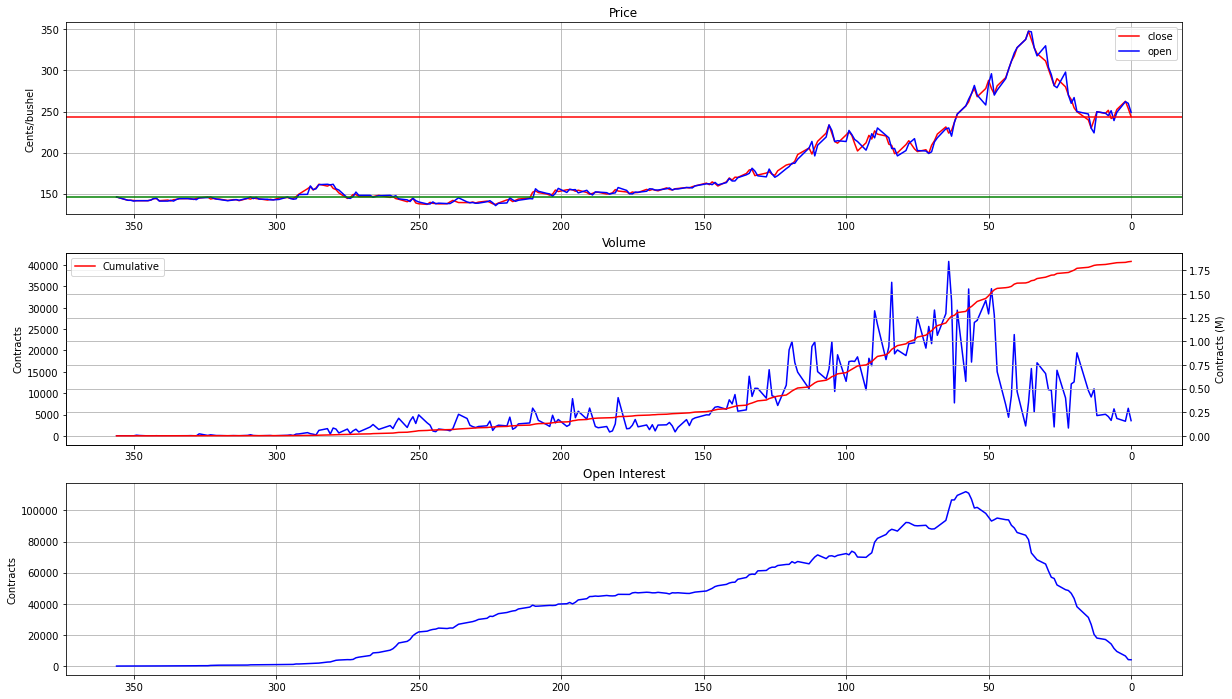

In [12]:
# sep 1973 contract is an outlier (40% high at ~35 days)
year = 1973
month = 9
contractPlots(data, year, month, which='avi')

Plots for contract 1973/7


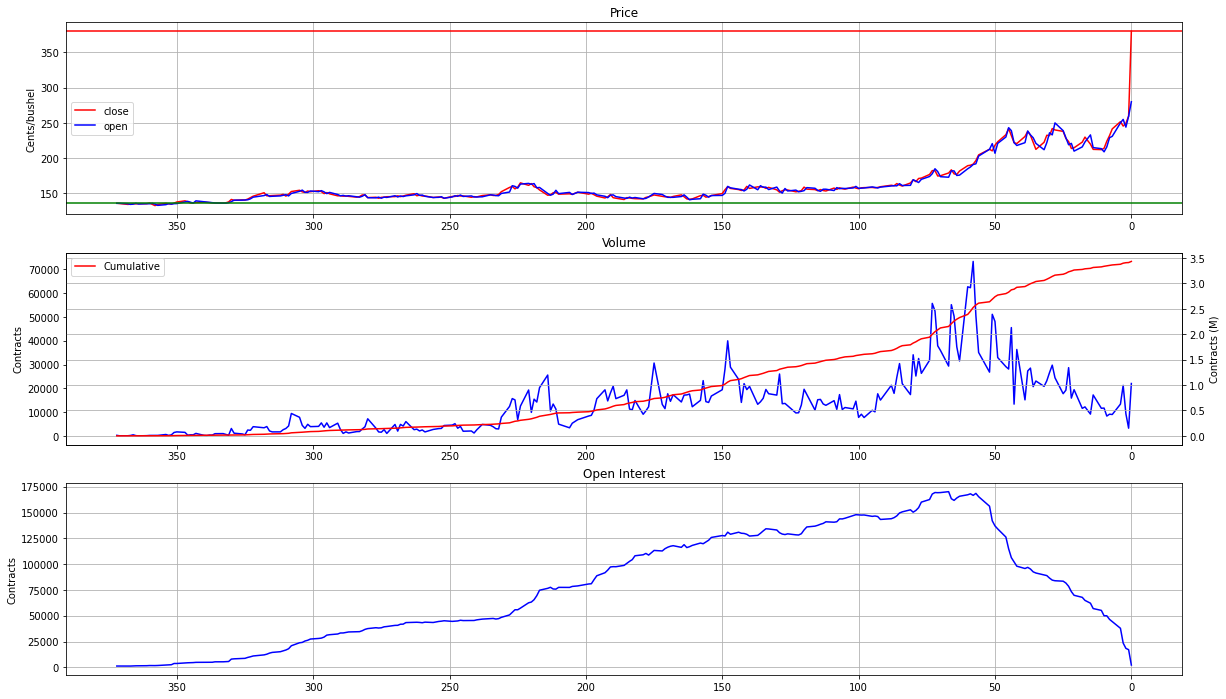

In [13]:
# sep 1973 contract is an outlier (40% high at ~35 days)
year = 1973
month = 7
contractPlots(data, year, month, which='avi')

In [14]:
_d2 = data[(data['month']==7) & (data['year']==1973)]
_d2[_d2['day']<5]

,year,month,open,close,open_net,close_net,open_rel,close_rel,volume,openint,day,date
17585,1973,7,250.0,251.75,-130.0,-128.25,0.657895,0.662500,13350,37870,4,1973-07-16
17590,1973,7,255.0,245.50,-125.0,-134.50,0.671053,0.646053,21235,23570,3,1973-07-17
17595,1973,7,244.0,249.50,-136.0,-130.50,0.642105,0.656579,9280,18425,2,1973-07-18
17602,1973,7,259.5,259.50,-120.5,-120.50,0.682895,0.682895,3230,17130,1,1973-07-19
17607,1973,7,280.0,380.00,-100.0,0.00,0.736842,1.000000,22020,2270,0,1973-07-20


Plots for contract 1994/7


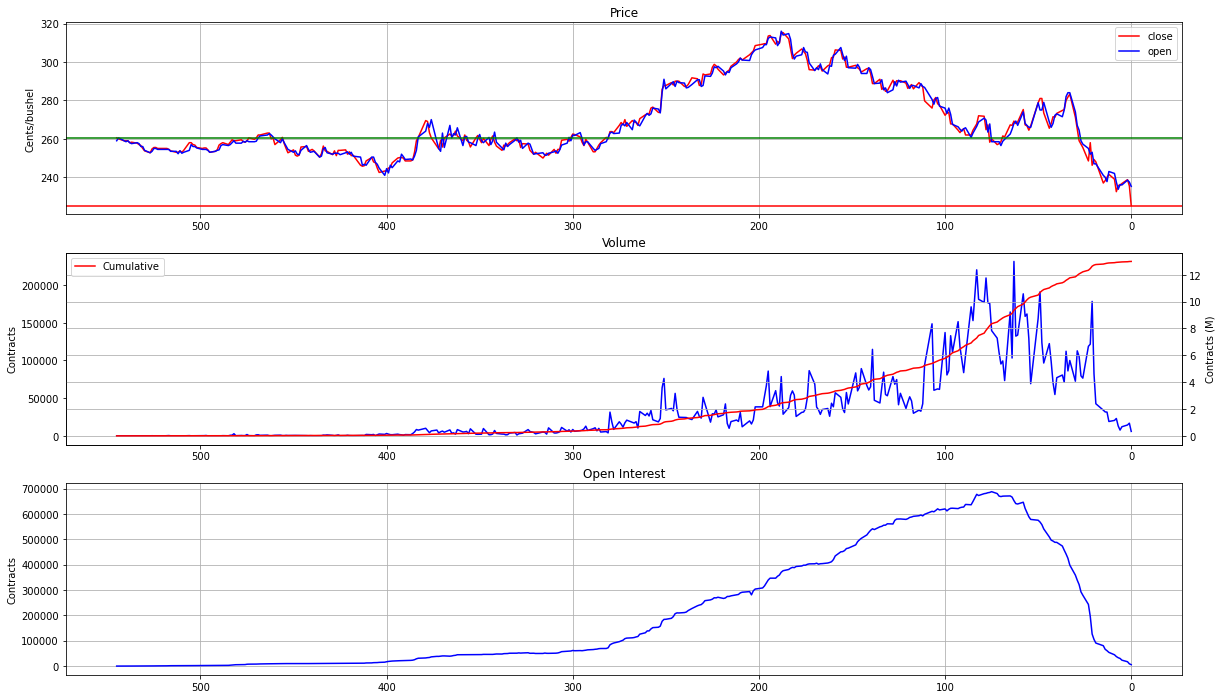

In [15]:
# jul 1994 contract is an outlier (30% high at ~30 days) but it has high open_int
year = 1994
month = 7
contractPlots(data, year, month, 'avi')

# Open int
Open interest is the total number of open contracts.

In [16]:
# find maximum open interest and days contract is open
openint_max = data.drop(columns=['open', 'close', 'close_rel', 'open_rel', 'close_net', 'open_net', 'volume', 'date'])
openint_max = openint_max.groupby(['month', 'year']).max()
#openint_max = openint_max.sort_values(by='openint')
#openint_max[openint_max['openint']<100000]

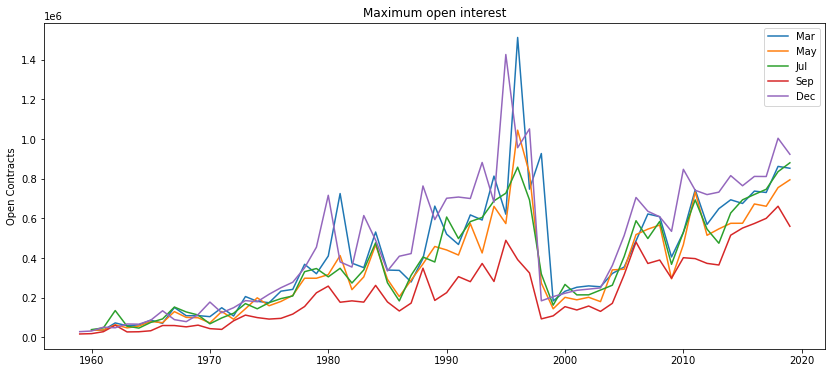

In [17]:
plt.rcParams["figure.figsize"]=14,6
months = [3,5,7,9,12]
names = ['Mar', 'May', 'Jul', 'Sep', 'Dec']
for n in range(len(months)):
    plt.plot(
        openint_max.loc[(months[n],slice(None))]['openint'],
        # openint_max.loc[openint_max.index.get_level_values('month')==month]['openint'][-21:].set_index(drop=True), 
        label=str(names[n]))
plt.title("Maximum open interest")
plt.ylabel('Open Contracts')
plt.legend()
#plt.plot(openint_max.loc[openint_max.index.get_level_values('month')==9])

# All years
Support code

In [18]:
def allYears(col, month, y, days=None):
    _df = data[data['month'] == month]
    years = pd.unique(_df['year'])
    fig, ax = plt.subplots()
    plt.axhline(y=y, color='black')
    plt.xlabel('Days before expiration')
    ax.invert_xaxis()
    for year in years:
        _df2 = _df[_df['year']==year]
        if days:
            _df2 = _df2[_df2['day'] <= days]
        plt.plot(_df2['day'], _df2[col])

## All years: Net close

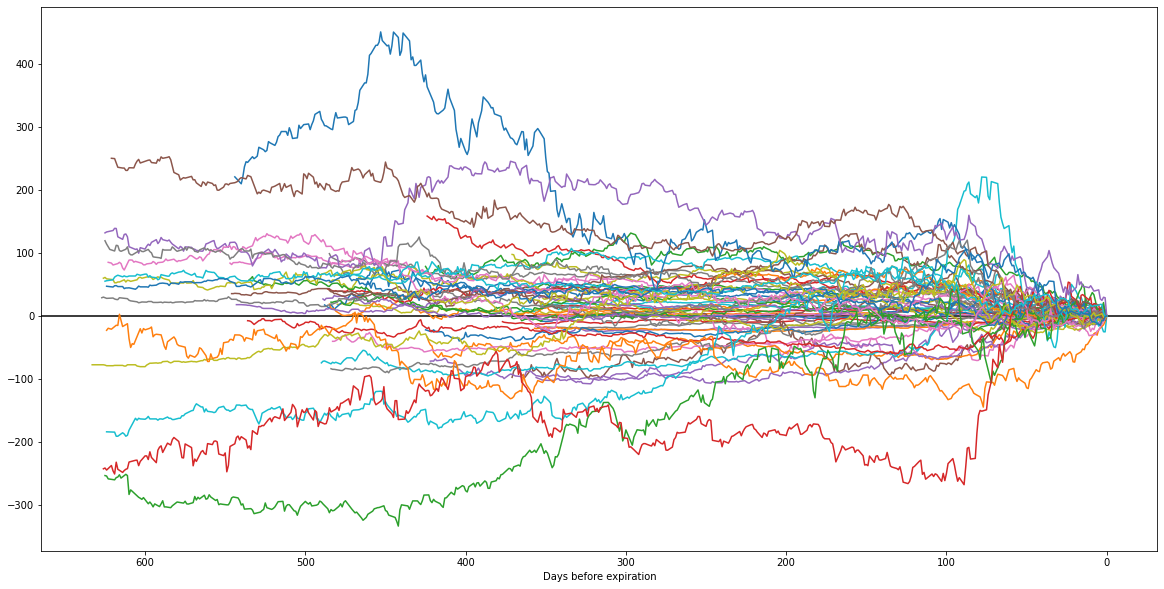

In [19]:
month = 9
plt.rcParams["figure.figsize"]=20,10
allYears('close_net', month, 0.)

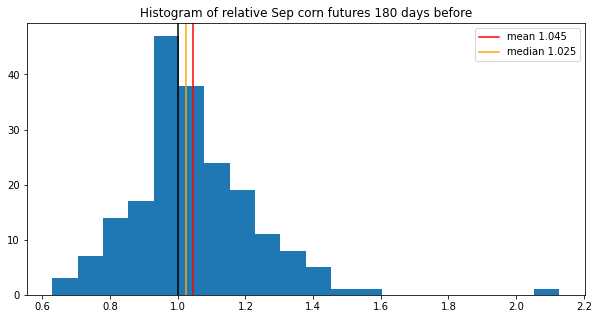

In [22]:
plt.rcParams["figure.figsize"]=10,5
sep = data[data['month']==9]

sep = sep[sep['year']>2000]

#days = range(90, 500, 90)
days = [180]

fig, axes = plt.subplots(len(days), 1, sharex=True, sharey=True)

for n, tgt in enumerate(days):
    _ = data[data['day']==tgt]['close_rel']
    ax = axes#[n]

    ax.axvline(x=1.0, color='black')
    mean = _.mean()
    median = _.median()
    ax.axvline(x=mean, color='red', label='mean {:.3f}'.format(mean))
    ax.axvline(x=median, color='orange', label='median {:.3f}'.format(median) )
    ax.hist(_, bins=20)
    ax.set_title(f'Histogram of relative Sep corn futures {tgt} days before')
    ax.legend()

plt.show()

## All years: Relative close

In [ ]:
month = 9
plt.rcParams["figure.figsize"]=20,10
allYears('close_rel', month, 1.)

In [ ]:
month = 9
plt.rcParams["figure.figsize"]=20,10
allYears('close_rel', month, 1., days=24)

In [ ]:
def overallStats(dfin, month, days=200):
    meanlist = []
    rellist = []
    varlist = []
    vollist = []
    openintlist = []
    days = range(days)

    df = dfin[dfin['month']==month]
    for i in days:
        meanlist.append(df[df['day']==i]['close_net'].mean())
        rellist.append(df[df['day']==i]['close_rel'].mean())
        varlist.append(df[df['day']==i]['close_net'].var())
        vollist.append(df[df['day']==i]['volume'].mean())
        openintlist.append(df[df['day']==i]['openint'].mean())

    plt.rcParams["figure.figsize"]=20,16

    ax = plt.subplot(4, 1, 1)
    ax.invert_xaxis()
    plt.plot(days, meanlist, 'g-')
    plt.grid(b=True, which='major')
    plt.title('Net Close - Mean')
    # plt.axhline(y=0, color='red')
    plt.ylabel('Net')

    #ax = plt.subplot(5, 1, 2)
    #ax.invert_xaxis()
    #plt.plot(days, rellist, 'g-')
    #plt.grid(b=True, which='major')
    #plt.title('Relative Close - Mean')
    #plt.ylabel('Relative')

    ax = plt.subplot(4, 1, 2)
    ax.invert_xaxis()
    plt.plot(days, varlist, 'b-')
    plt.grid(b=True, which='major')
    plt.title('Net Close - Var')
    plt.ylabel('Variance')

    ax = plt.subplot(4, 1, 3)
    ax.invert_xaxis()
    plt.plot(days, vollist, 'b-')
    plt.grid(b=True, which='major')
    plt.title('Volume')
    plt.ylabel('Contracts')

    ax = plt.subplot(4, 1, 4)
    ax.invert_xaxis()
    plt.plot(days, openintlist, 'b-')
    plt.grid(b=True, which='major')
    plt.title('Openint')
    plt.ylabel('Contracts')

# Overall statistics
The plots below show the aggregate (mean or variance) of all years by day. For example, at 200 on the x-axis, we see the average of all net close prices 200 days before the contract end.

In [ ]:
overallStats(data, 3)

# Granger causality
The Null hypothesis for grangercausalitytests is that the time series in the second column, x2, does NOT Granger cause the time series in the first column, x1. Grange causality means that past values of x2 have a statistically significant effect on the current value of x1, taking past values of x1 into account as regressors. We reject the null hypothesis that x2 does not Granger cause x1 if the pvalues are below a desired size of the test.

The null hypothesis for all four test is that the coefficients corresponding to past values of the second time series are zero.

‘params_ftest’, ‘ssr_ftest’ are based on F distribution

‘ssr_chi2test’, ‘lrtest’ are based on chi-square distribution

In [ ]:
# https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.grangercausalitytests.html
from statsmodels.tsa.stattools import grangercausalitytests

In [ ]:
data

In [ ]:
d02 = data[data['year']==2002].copy()
#d02['date'] = pd.to_datetime(d02['date'])
d02['date_'] = pd.to_datetime(d02['date'])
d02 = d02.drop(columns=(['year', 'close', 'open_net', 'close_net', 'open_rel', 'close_rel', 'volume', 'day', 'date', 'openint']))
d02 = d02.rename(columns={'date_': 'date'})
d02['month'].unique()

In [ ]:
mar02 = d02[d02['month']==3].drop(columns='month').rename(columns={'open': 'mar'})
may02 = d02[d02['month']==5].drop(columns='month').rename(columns={'open': 'may'})
jul02 = d02[d02['month']==7].drop(columns='month').rename(columns={'open': 'july'})
sep02 = d02[d02['month']==9].drop(columns='month').rename(columns={'open': 'sep'})

In [ ]:
left = mar02.copy()
right = sep02.copy()
_df = right.merge(left).drop(columns='date')
r = grangercausalitytests(_df, [180])

In [ ]:
# results returned from grainer is a dictionary keyed by lag (integer).
# the value at results[lag] is a 2-tuple
# the first item in the tuple is a dict of results of the tests; second item is not understood at this time
# key is test name; results of tests are 3 or 4 tuple. The second result ([1]) is the p-value
# example of this dict is below.
# {'ssr_ftest': (1.5328912836909083, 0.030747206701970127, 57.0, 180),
#  'ssr_chi2test': (2023.4164944719992, 7.81383224635291e-309, 180),
#  'lrtest': (737.7082395975993, 1.4470880239491697e-68, 180),
#  'params_ftest': (1.5328912836904054, 0.03074720670206777, 57.0, 180.0)}

def checkGC(left, right, lags, verbose=False):
    left = left.copy()
    right = right.copy()
    df = left.merge(right).drop(columns='date')
    try:
        r = grangercausalitytests(df, lags, verbose=verbose)
    except ValueError:
        return {}
    results = {}
    for key in r.keys():
        results[key] = {}
        for test, vals in r[key][0].items():
            results[key][test] = vals[1]
    return results

In [ ]:
years = range(1995, 2003)
lags = [180, 120, 60]
verbose = False
tests = ['ssr_ftest', 'ssr_chi2test', 'lrtest', 'params_ftest']

print('YEAR MON  LAG {:>12s} {:>12s} {:>12s} {:>12s} {:>12s}'.format(*tests, 'max'))
for year in years:
    _df = data[data['year']==year].copy()
    _df['date_'] = pd.to_datetime(_df['date'])
    columns=['year', 'close', 'open_net', 'close_net', 'open_rel', 'close_rel', 'volume', 'day', 'date', 'openint']
    _df = _df.drop(columns=columns)
    _df = _df.rename(columns={'date_': 'date'})
    series = dict(
        mar = _df[_df['month']==3].drop(columns='month').rename(columns={'open': 'mar'}),
        may = _df[_df['month']==5].drop(columns='month').rename(columns={'open': 'may'}),
        jul = _df[_df['month']==7].drop(columns='month').rename(columns={'open': 'jul'}),
        sep = _df[(_df['month']==9)|(_df['month']==10)].drop(columns='month').rename(columns={'open': 'sep'}),
    )

    for n, mon in enumerate(['mar', 'may', 'jul']):
        # check pairwise granger
        l = [1, lags[n]]
        r = checkGC(series['sep'], series[mon], l)
        for lag, val in r.items():
            pvalues = [val[test] for test in tests]
            print("{:4d} {} {:4d} {:12.8f} {:12.8f} {:12.8f} {:12.8f} {:12.8f}".format(
                year, mon, lag, *pvalues, max(pvalues)))

In [6]:
data.head()

,year,month,open,close,open_net,close_net,open_rel,close_rel,volume,openint,day,date
0,1960,5,119.4,119.5,0.8,0.9,1.006745,1.007589,21,397,323,1959-07-01
1,1959,9,120.2,119.7,7.2,6.7,1.063717,1.059292,3952,13997,82,1959-07-01
2,1960,3,118.0,117.7,4.3,4.0,1.037819,1.035180,541,7505,265,1959-07-01
3,1959,12,114.6,114.3,7.3,7.0,1.068034,1.065238,2528,17694,173,1959-07-01
4,1960,3,117.6,117.6,3.9,3.9,1.034301,1.034301,1156,7897,264,1959-07-02


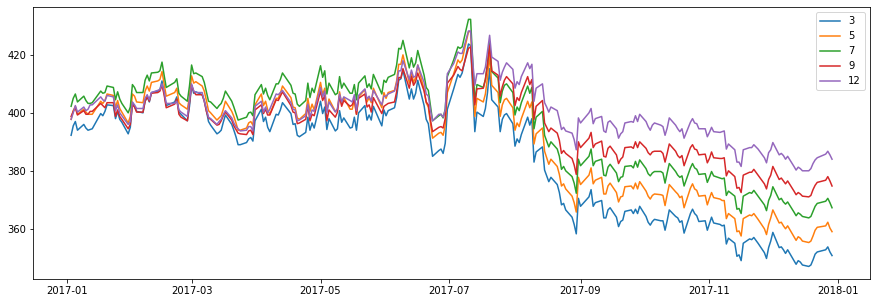

In [53]:
plt.figure(figsize=(15,5))

_df = data[(data['date'].dt.year==2017)&(data['year']==data['date'].dt.year+1)]
#_df = _df[_df['date'].dt.month==6]
_df.head()
for m in np.sort(_df['month'].unique()):
    _ = _df[_df['month']==m]
    plt.plot(_['date'], _['close'], label=str(m))
plt.legend()

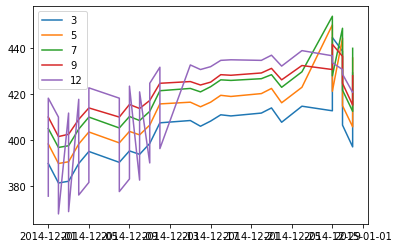

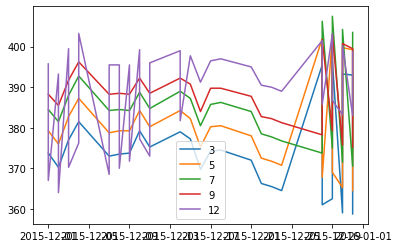

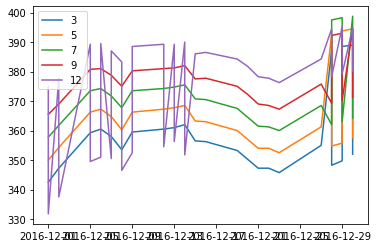

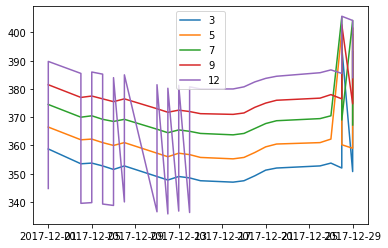

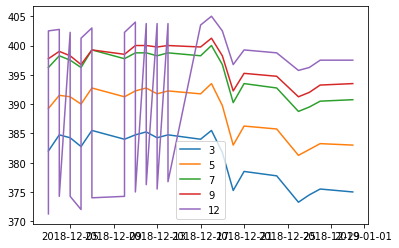

In [25]:
_df = data[data['date'].dt.year>=2014]
#print(_df.head())
_df = _df[_df['date'].dt.month==12]
for y in range(2014, 2019):
    _y = _df[_df['date'].dt.year == y]
    for m in np.sort(_y['month'].unique()):
        _ = _y[_y['month']==m]
        plt.plot(_['date'], _['close'], label=str(m))
    plt.legend()
    plt.show()

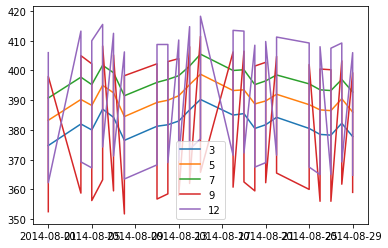

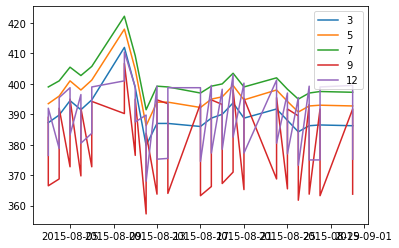

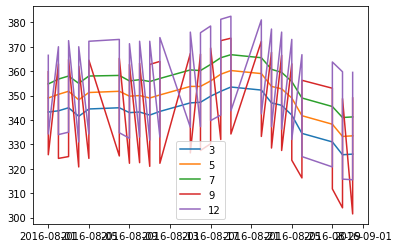

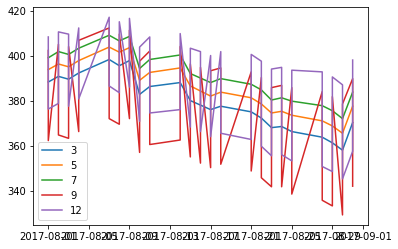

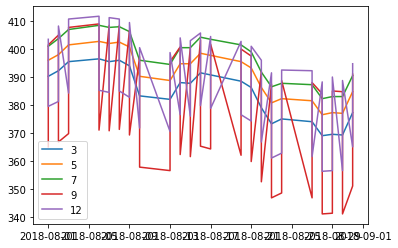

In [30]:
_df = data[data['date'].dt.year>=2014]
#print(_df.head())
_df = _df[_df['date'].dt.month==8]
for y in range(2014, 2019):
    _y = _df[_df['date'].dt.year == y]
    for m in np.sort(_y['month'].unique()):
        _ = _y[_y['month']==m]
        plt.plot(_['date'], _['close'], label=str(m))
    plt.legend()
    plt.show()